In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.functional as FA
import torchaudio.transforms as TT
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path
from IPython.display import Audio

import matplotlib.pyplot as plt
import psutil
import requests
from sklearn.model_selection import train_test_split
from utils import *
from datasets import *
from models import *
from transforms import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import  seaborn as sns

from torchvision.models import densenet121, resnext101_32x8d, mobilenet_v3_small, densenet169
import torch.optim as optim


Available workers: 16


In [3]:
train_or_load_pretrained = "load" # Set this to "train" if you want to train a new network
pretrained_modelname = "model_stft_best"
num_epochs = 50
batch_size = 16
batch_size_val = 16
validation_split = .3
shuffle_dataset = True
num_workers = 4
random_seed= 42
setting = 'stftcropresize'# 'stft', 'reassigned_stft', 'melstft'
modeltype = 'densenet121'#'resnext101' # 'resnet34','resnet152'

train_df = pd.read_parquet('../data_created/suzmel_train.parquet')
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')

transforms_list_train = [Bandpass(lowcut=140, highcut=1500), RandomRoll(p=1.) ,RandomFlip(), RandomNoise(p=7.), TransformWingbeat(setting=setting)]#, RandomNoise(), RandomRoll()]
transforms_list_test = [Bandpass(lowcut=140, highcut=1500), TransformWingbeat(setting=setting)]

X, y = train_df.iloc[:, 0], train_df.iloc[:, 1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, shuffle=True, random_state=42, stratify=y)
X_test, y_test = test_df.iloc[:,0], test_df.iloc[:,1]

train_dataset = DataFrameset(pd.concat([X_train, y_train], axis=1), transform=transforms.Compose(transforms_list_train))
valid_dataset = DataFrameset(pd.concat([X_valid, y_valid], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataset = DataFrameset(pd.concat([X_test, y_test], axis=1), transform=transforms.Compose(transforms_list_test))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

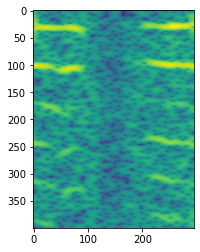

In [4]:
plt.imshow(train_dataset[0][0][0]);

In [5]:
train_dataset[0][0][0].shape

torch.Size([400, 295])

In [6]:
outs=2
if modeltype in ['densenet121', 'densenet169']:
    if modeltype=='densenet121':
        model = densenet121(pretrained=False)
    elif modeltype=='densenet169':
        model = densenet169(pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,2)

elif modeltype == 'resnext101':
    model = resnext101_32x8d(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,2)
elif modeltype == 'mobilenet_v3_small':
    model = mobilenet_v3_small(pretrained=False)
    num_ftrs = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_ftrs,2)



class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count    

if outs == 1:
    criterion = torch.nn.BCEWithLogitsLoss(label_smoothing=0.25, weight=torch.Tensor(weight).cuda())
elif outs == 2:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.25, weight=torch.Tensor(weight).cuda())

optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")
# early_stopping = EarlyStopping(patience=10, verbose=1)

## Training

In [7]:
if train_or_load_pretrained == 'train':
    # Choosing whether to train on a gpu
    train_on_gpu = torch.cuda.is_available()
    print(f'Train on gpu: {train_on_gpu}')# Number of gpus
    model = model.to('cuda', dtype=torch.float)

    results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
    best_valacc = 0
    # Model training
    for epoch in range(num_epochs):
        # Going through the training set
        correct_train = 0
        model.train()
        for x_batch,y_batch,_,_ in tqdm(train_dataloader, desc='Training..\t'):          
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            for param in model.parameters():
                param.grad = None
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
        train_accuracy = correct_train / len(train_dataset) * 100.
        torch.cuda.empty_cache()


        # Going through the validation set
        correct_valid = 0
        model.eval()
        with torch.no_grad():
            for x_batch,y_batch,_,_ in tqdm(valid_dataloader, desc='Validating..\t'):
                y_batch = torch.as_tensor(y_batch)
                x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
                pred = model(x_batch)

                y_batch = y_batch.type(torch.LongTensor).cuda()
                correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
                val_loss = criterion(pred, y_batch)
        valid_accuracy = correct_valid / len(valid_dataset) * 100.

        scheduler.step()


        # Printing results
        print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")

        is_best = valid_accuracy > best_valacc
        if is_best:
            print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
        best_valacc = max(valid_accuracy, best_valacc)
        save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_valacc': best_valacc,
            'loss': results['loss'].append(loss.detach().cpu()),
            'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
            'train_accuracy': results['train_accuracy'].append(train_accuracy),
            'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
            'optimizer' : optimizer.state_dict(),
        }, is_best, f"model_stft")

elif train_or_load_pretrained == 'load':
    model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/{pretrained_modelname}.pth.tar', model, optimizer)
    model = model.to('cuda', dtype=torch.float)
else:
    print("Set train_or_load_pretrained to either \'train\' or \'load\'")

## Testing on test set

In [8]:
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_stft_best.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

In [9]:
_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 1605/1605 [17:26<00:00,  1.53it/s]

Accuracy: 85.58
Balanced accuracy: 85.01
Confusion matrix: 
[[0.74824598 0.25175402]
 [0.0480826  0.9519174 ]]


## Testing on extra mebios data

In [10]:
extra_df = pd.read_parquet('../data_created/suzmel_extra.parquet')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [11]:
_ = test_model(model,extra_dataloader, extra_dataset)

Testing..	: 100%|██████████| 1422/1422 [15:19<00:00,  1.55it/s]

Accuracy: 92.21
Balanced accuracy: 86.49
Confusion matrix: 
[[0.80119454 0.19880546]
 [0.07129612 0.92870388]]
